In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '../LaurieOnTracking')
import Metrica_IO as mio
import Metrica_Viz as mviz
from itertools import groupby
import ast

In [2]:
result_matches = [] 

In [3]:
matches = ['metrica_1', 'metrica_2']
match = 'metrica_1'

In [4]:
# load event data from Metrica always to use reverse function
DATADIR = '../sample-data-master/data'
game_id = 1 # let's look at sample match 2

# read in the event data
events = mio.read_event_data(DATADIR,game_id)
if (match == 'metrica_1') or (match == 'metrica_2'):
    if match == 'metrica_1':
        game_id = 1 # let's look at sample match 1
    elif match == 'metrica_2':
        game_id = 2

    # read in the event data
    events = mio.read_event_data(DATADIR,game_id)

    # Bit of housekeeping: unit conversion from metric data units to meters
    events = mio.to_metric_coordinates(events)
    events.head()
    #### TRACKING DATA ####

    # READING IN TRACKING DATA
    tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
    tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

    # Convert positions from metrica units to meters 
    tracking_home = mio.to_metric_coordinates(tracking_home)
    tracking_away = mio.to_metric_coordinates(tracking_away)
    # reverse direction of play in the second half so that home team is always attacking from right->left
    tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)
    if match=='metrica_1':
        tracking_home, tracking_away, events= mio.change_playing_direction_both(tracking_home, tracking_away, events)
    #query features
    query_features = pd.read_csv('.././results' + '/metrica_' + str(game_id) +
                                     '_query_features.csv', sep=";")
    


Reading team: home
Reading team: away


In [5]:
# ball laying still--> set piece or outside
#when zero ball velocity or nan --> "Out"
query_features['close to ball'] = np.where((pd.isnull(query_features['ball velocity'])) |(query_features['ball velocity']== 0) | (pd.isnull(query_features['close to ball']))
                                           , "Out", query_features['close to ball'])
#
event = query_features['close to ball']
values = [event, event.shift(-1), event.shift(-2), event.shift(-3), event.shift(-4), event.shift(-5)]
sequence = np.all([v == values[0] for v in values], axis=0)
#[event[x]= np.where(sequence[x], event[x], event[x-1]) for x in range(1, len(event))]
possession = []
value = 'Out'
# loop through possession, is 5 in a row change,
for x in range(len(event)):
    if sequence[x]:
        value = event.iloc[x]
    elif value == 'Out': #changes when ball out or set piece
        value=event.iloc[x]
    possession.append(value)
    
query_features['possession'] = possession
#query_features = query_features.drop(columns=['closest to ball_home', 'closest to ball_away', 'close to ball'])

In [6]:
# ball possession
query_features['phase'] = (query_features['possession'] != query_features['possession'].shift(1)).fillna(0).cumsum(skipna=False)
phases = query_features.groupby('phase').agg(
        Condition=('possession', 'first'),
        Start_frame=('frame', 'first'),
        End_frame=('frame', 'last')
        )

In [7]:
# total kickoff
if (match == 'metrica_1') or (match == 'metrica_2'):
    goalkicks = events[events.Subtype == 'GOAL KICK']
elif (match == 'dfb_1') or (match == 'dfb_2'):
    goalkicks = events[events.Subtype == 'GoalKick']
    
goalkicks

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
81,Away,PASS,GOAL KICK,1,6685,267.40,6779,271.16,Player25,Player18,-47.70,-3.40,-3.18,-31.28
168,Home,PASS,GOAL KICK,1,13543,541.72,13625,545.00,Player11,Player5,48.76,-4.08,-0.00,24.48
241,Away,PASS,GOAL KICK,1,18558,742.32,18606,744.24,Player25,Player17,-48.76,6.80,-36.04,28.56
427,Away,PASS,GOAL KICK,1,31546,1261.84,31597,1263.88,Player25,Player17,-48.76,8.16,-41.34,25.84
756,Away,PASS,GOAL KICK,1,60792,2431.68,60882,2435.28,Player25,Player18,-48.76,-0.68,6.36,-34.00
776,Away,PASS,GOAL KICK,1,63239,2529.56,63287,2531.48,Player25,Player17,-47.70,-3.40,-26.50,-30.60
890,Home,PASS,GOAL KICK,1,70460,2818.40,70512,2820.48,Player11,Player7,48.76,-2.04,37.10,25.84
965,Away,BALL LOST,GOAL KICK,2,77582,3103.28,77582,3103.28,Player25,NaN,-47.70,3.40,-6.36,-21.76
1126,Away,PASS,GOAL KICK,2,92578,3703.12,92648,3705.92,Player25,Player19,-47.70,-1.36,-1.06,-21.08
1460,Away,PASS,GOAL KICK,2,119733,4789.32,119768,4790.72,Player25,Player15,-48.76,-0.00,-42.40,-22.44


In [8]:
query_features.reset_index()
query_features.index +=1
query_features.head(10)

,frame,ball x,ball y,ball velocity,inside,zone,centroid x_home,centroid y_home,centroid_zone_home,rest defence_home,...,centroid y_away,centroid_zone_away,rest defence_away,width_away,length_away,occupancy map_away,team distance_away,close to ball,possession,phase
1,1,-4.210850,-7.976468,NaN,True,8.0,10.094571,-5.163961,11.0,9.0,...,-1.267493,8.0,5.0,60.867956,31.771274,"[0, 1, 0, 0, 2, 4, 1, 2]",9.028938,Out,Out,1
2,11,-7.553878,-17.627436,28.560805,True,9.0,10.047931,-6.105054,11.0,10.0,...,-1.857080,8.0,3.0,61.266504,32.389466,"[0, 0, 0, 1, 3, 6, 0, 0]",10.760712,Away,Away,2
3,21,-7.182348,-20.427676,2.905701,True,9.0,10.163927,-7.137878,11.0,10.0,...,-2.569088,8.0,2.0,61.505456,33.046666,"[1, 0, 0, 0, 3, 6, 0, 0]",10.939565,Away,Away,2
4,31,-6.145138,-20.814868,2.765478,True,9.0,10.325661,-8.100731,11.0,10.0,...,-3.244396,8.0,3.0,61.649412,33.450950,"[1, 0, 0, 0, 3, 6, 0, 0]",10.681626,Away,Away,2
5,41,-4.389248,-20.411492,2.537699,True,9.0,10.513568,-8.882724,11.0,10.0,...,-3.826360,11.0,4.0,61.650500,33.563098,"[0, 0, 1, 0, 3, 6, 0, 0]",9.918641,Away,Away,2
6,51,1.426230,-16.040588,20.190681,True,12.0,10.687895,-9.395410,11.0,8.0,...,-4.240868,11.0,5.0,61.494848,33.277428,"[1, 0, 1, 0, 1, 5, 1, 1]",8.839663,Out,Away,2
7,61,5.179584,-13.019212,20.190681,True,12.0,10.807898,-9.567083,11.0,8.0,...,-4.435932,11.0,6.0,61.229512,32.544226,"[0, 1, 0, 0, 1, 5, 2, 1]",8.296240,Away,Away,2
8,71,4.942462,-12.285152,1.199442,True,12.0,10.849757,-9.377771,11.0,8.0,...,-4.366783,11.0,5.0,60.832120,31.559168,"[0, 1, 0, 1, 1, 4, 2, 1]",8.035096,Away,Away,2
9,81,3.466730,-7.746288,14.779685,True,11.0,10.857654,-8.845392,11.0,8.0,...,-4.019970,11.0,5.0,60.324908,30.543794,"[0, 1, 0, 1, 2, 3, 1, 2]",8.537391,Home,Away,2
10,91,1.807194,-2.583728,14.779685,True,11.0,10.904093,-8.020688,11.0,8.0,...,-3.428302,11.0,5.0,59.681900,29.589158,"[0, 1, 1, 1, 2, 2, 1, 2]",9.867063,Away,Away,2


In [9]:
# goal counterattack
query=query_features.copy()
counterattack = []

conditionA = [(query['possession'] == 'Home'), 12]
conditionB = [(query['possession']== 'Away'), 12]
conditionC = [(query['possession']== 'Away') & (
                (query.zone == 7) | (query.zone == 8) | (query.zone == 9) | (query.zone == 10) | 
                (query.zone == 11) | (query.zone == 12) 
                ) & (query['rest defence_home'] <=4)
              , 150]
conditionD = [((query.zone == 14) | (query.zone == 17)) & (query.possession == 'Away'), 1]
counterattack.append([conditionA, conditionB, conditionC, conditionD])#

conditionA = [(query['possession'] == 'Away'), 12]
conditionB = [(query['possession'] == 'Home'), 12]
conditionC = [(query['possession']== 'Home') & (
                (query.zone == 7) | (query.zone == 8) | (query.zone == 9) | (query.zone == 10) | 
                (query.zone == 11) | (query.zone == 12)
                ) & (query['rest defence_away'] <=4)
                , 150]
conditionD = [((query.zone == 2) | (query.zone == 5)) & (query['possession']== 'Home'), 1]
counterattack.append([conditionA, conditionB, conditionC, conditionD])#

# transition
# speed
# pass cuts out number of defenders
# end in zone 14 or 17

In [10]:
def find_intervals(query_interval, condition, extra_time):
    """
    Method to find intervals that meet the condition
    
    params:
        query_interval: dataframe with feature values
        condition: list with true/false values for on query_interval for a certain condition
        extra:time: number of frames till the next condition

    returns:
        intervals: list with [start_frame, range()]
    """
    query_interval['cond'] = condition
    query_interval['phase'] = (query_interval['cond'] != query_interval['cond'].shift(1)).fillna(0).cumsum(skipna=False)
    phases= query_interval.groupby('phase').agg(
        Condition=('cond', 'first'),
        Start_frame=('frame', 'first'),
        End_frame=('frame', 'last')
        )
    phases = phases[phases.Condition]
    intervals = [[[], range(phases.Start_frame.iloc[x], phases.End_frame.iloc[x]+extra_time)] for x in range(len(phases))]
    return intervals




In [11]:
def find_intervals_custom(query_interval, condition, extra_time):
    """
    Method to find intervals that meet the condition
    
    params:
        query_interval: dataframe with feature values
        condition: list with true/false values for on query_interval for a certain condition
        extra:time: number of frames till the next condition

    returns:
        intervals: list with [start_frame, range()]
    """
    query_interval['cond'] = condition
    query_interval['phase'] = (query_interval['cond'] != query_interval['cond'].shift(1)).fillna(0).cumsum(skipna=False)
    phases= query_interval.groupby('phase').agg(
        Condition=('cond', 'first'),
        Start_frame=('frame', 'first'),
        End_frame=('frame', 'last'),
        mean_ball_velo=('ball velocity', 'mean'),
        rest_start = ('rest defence_home', 'first'),
        rest_end = ('rest defence_home', 'last')
        )
    #phases['rest_difference'] = phases['rest_end'] - phases['rest_start']
    phases = phases[(phases.Condition)]# & (phases['rest_difference'] > 0)]
    intervals = [[[], range(phases.Start_frame.iloc[x], phases.End_frame.iloc[x]+extra_time)] for x in range(len(phases))]
    return intervals


In [12]:
def check_conditions(query, conditions, framesize = 10):
    """
    Function to verify which conditions are indivually met
    
    params:
        query: Dataframe with feature items 
        conditions: listed with conditions in formation [["A", query.inside==False, int(sequence)], ...]
        framesize: the size of a frame, typically 10
    returns
        df query with additional column query that has letters for the conditions he meet
    """
    for condition in range(len(conditions)):
        if condition == 0:
                        query['query'] = np.where(conditions[condition][0], "L" + str(condition), "")
        else:
            query['query'] = query['query'] + np.where(conditions[condition][0], "L" + str(condition), "")

        # to verify sequences
        #if not np.isnan(conditions[condition][2]):
        #    sequence = conditions[condition][2]
        #    letter = conditions[condition][0]
        #    check_seq = [check_sequence_condition(query, letter, frame, framesize, sequence) for frame in query.frame]
        #    query['query'] = check_seq
    return query


test = check_conditions(query_features, counterattack[0], 10)
#test[(test.frame >=133263) & (test.frame<=133563)]

In [13]:
def find_intersections(intervals_combi, intervals_new):
    ''' Function to find which intervalt that intersect with each other
    
    params:
        intervals_combi: list with [[ranges[, range]
        intervals_new: list with [[ranges], range]
    returns:
        intersections: a list of ranges from intervalsB that intersect with intervalS
    ''' 
   
    intervalsA = [intervals_combi[x][1] for x in range(len(intervals_combi))]
    old_intervals = [intervals_combi[x][0] for x in range(len(intervals_combi))]
    intervalsB = [intervals_new[x][1] for x in range(len(intervals_new))]

    intersections= []
    
    i = j = 0
    valueA = np.nan
    valueB = np.nan
    while i < len(intervalsA) and j < len(intervalsB):
        # a before b, otherwise increase j
        if min(intervalsA[i]) > min(intervalsB[j]):
            j +=1
            continue
                  
        # Left bound for intersecting segment / biggest start          
        left = max(min(intervalsA[i]), min(intervalsB[j]))
        # Right bound / smallest end point
        right = min(max(intervalsA[i]), max(intervalsB[j]))
            
        if left <= right:
            # deal with two different intervals after for the same A
            if intervalsA[i] != valueA:
                old_interval = old_intervals[i]
                old_interval.append(intervalsA[i])
            if intervalsB[j] != valueB:
                intersections.append([old_interval, intervalsB[j]])
                valueA = intervalsA[i]
                valueB = intervalsB[j]
       
        # If i-th interval's right bound is  
        # smaller increment i else increment j 
        if max(intervalsA[i]) < max(intervalsB[j]):
            i += 1
        else:
            j += 1
        
    return intersections

In [14]:
def check_results(test, conditions):
    """ Functions that checks which episodes meet the conditions
    
    Params:
        test: DF with all features
        conditions: listed with conditions in formation [["A", query.inside==False], ...]
    returns:
        results: list with all episodes that meet the conditions
    """
    # Check conditions and put letter in query DF
    interval_combi = find_intervals(test, conditions[0][0], conditions[0][1])
    
    for num_cond in range(1, len(conditions)):
        if num_cond==20:
            interval = find_intervals_custom(test, conditions[num_cond][0], conditions[num_cond][1])
        else:
            interval = find_intervals(test, conditions[num_cond][0], conditions[num_cond][1]) 
        interval_combi = find_intersections(interval_combi, interval)


    return interval_combi
        

# get all results and make episode of it
new_results = []
#for corner in cornerQ:
for expression in counterattack:
    results = (check_results(query, expression))
    print(results)
    for item in results:
        try:
            start_time = min(item[0][0]) # item[0]
            end_time = max(item[1]) #- 51
            new_results.append(range(start_time-1*25, end_time+1*25))
        except: 
            continue


[[[range(103741, 104083), range(104081, 104253), range(104081, 104351)], range(104211, 104242)], [[range(104251, 105673), range(105671, 106043), range(105761, 105921)], range(105781, 105822)], [[range(116081, 116483), range(116481, 116683), range(116481, 116711)], range(116571, 116662)], [[range(135811, 136013), range(136011, 136653), range(136401, 136561)], range(136521, 136532)], [[range(135811, 136013), range(136011, 136653), range(136401, 136561)], range(136551, 136642)]]
[[[range(9251, 9433), range(9431, 9653), range(9431, 9631)], range(9621, 9642)], [[range(64101, 64323), range(64321, 64663), range(64431, 64651)], range(64511, 64532)], [[range(64101, 64323), range(64321, 64663), range(64431, 64651)], range(64601, 64622)], [[range(108241, 108613), range(108611, 109103), range(108801, 109111)], range(108971, 109092)], [[range(116481, 116683), range(116681, 118973), range(118131, 118281), range(118821, 118971)], range(118241, 118272)], [[range(116481, 116683), range(116681, 118973),

In [15]:
results

[[[range(9251, 9433), range(9431, 9653), range(9431, 9631)],
  range(9621, 9642)],
 [[range(64101, 64323), range(64321, 64663), range(64431, 64651)],
  range(64511, 64532)],
 [[range(64101, 64323), range(64321, 64663), range(64431, 64651)],
  range(64601, 64622)],
 [[range(108241, 108613), range(108611, 109103), range(108801, 109111)],
  range(108971, 109092)],
 [[range(116481, 116683),
   range(116681, 118973),
   range(118131, 118281),
   range(118821, 118971)],
  range(118241, 118272)],
 [[range(116481, 116683),
   range(116681, 118973),
   range(118131, 118281),
   range(118821, 118971)],
  range(118831, 118832)],
 [[range(116481, 116683),
   range(116681, 118973),
   range(118131, 118281),
   range(118821, 118971)],
  range(118911, 118912)],
 [[range(116481, 116683),
   range(116681, 118973),
   range(118131, 118281),
   range(118821, 118971)],
  range(118951, 118962)],
 [[range(127681, 128003), range(128001, 128373), range(128011, 128251)],
  range(128231, 128362)],
 [[range(1292

In [16]:
new_results

[range(103716, 104266),
 range(104226, 105846),
 range(116056, 116686),
 range(135786, 136556),
 range(135786, 136666),
 range(9226, 9666),
 range(64076, 64556),
 range(64076, 64646),
 range(108216, 109116),
 range(116456, 118296),
 range(116456, 118856),
 range(116456, 118936),
 range(116456, 118986),
 range(127656, 128386),
 range(129246, 130886)]

In [17]:
STOP
DATADIR = '../../data_clean/results/counterattack/temporal/' + match + '/'
PLOTDIR = DATADIR
start_minute = 12
end_minute = 13

counter = 0
for result in new_results: 
    start_frame= min(result)  # - 5*25
    end_frame = max(result) #+ 15*25
    home = tracking_home[(tracking_home.index >=start_frame) & (tracking_home.index <= end_frame)]
    away = tracking_away[(tracking_away.index >=start_frame) & (tracking_away.index <= end_frame)]
    counter+=1
    mviz.save_match_clip(home, away,PLOTDIR,fname='switch_'+ str(counter), include_player_velocities=False)


NameError: name 'STOP' is not defined

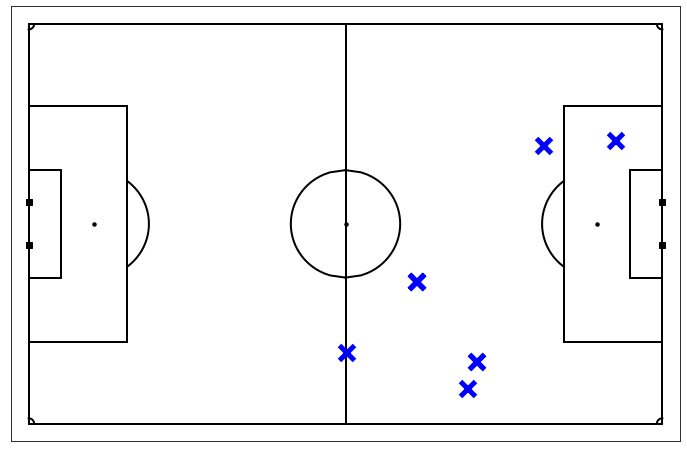

In [18]:

fig,ax = mviz.plot_pitch()
for range_result in results:
    loss = range_result[0][0]
    start = max(loss)
    #ax.plot(tracking_home[(tracking_home.index == start)]['ball_x'], \
    #        tracking_home[(tracking_home.index == start)]['ball_y'],'rd')
    
    #ax.plot(tracking_home[(tracking_home.index >= start) & (tracking_home.index <= end)]['ball_x'], \
    #        tracking_home[(tracking_home.index >= start) & (tracking_home.index <= end)]['ball_y'],'r')
    ax.plot(tracking_home[(tracking_home.index == start)]['ball_x'], \
            tracking_home[(tracking_home.index == start)]['ball_y'],'x', color='b', mew=5, ms=15)
    #ax.plot(tracking_home[(tracking_home.index == end)]['ball_x'], \
    #        tracking_home[(tracking_home.index == end)]['ball_y'],'ro')


#ax.plot(tracking_home['ball_x'].iloc[300],tracking_home['ball_y'].iloc[300],'ro')
#ax.plot(tracking_home['ball_x'].iloc[300:550+1],tracking_home['ball_y'].iloc[300:550+1],'r')